# PetFinder.my: Pawpularity Prediction Project

## Overview

### Executive Summary

Millions of stray animals are euthanized or left homeless every year. Research shows that the visual appeal of pet images can significantly influence adoption rates. Currently, PetFinder.my, Malaysia’s leading animal welfare platform, utilizes a basic “Cuteness Meter” to score pet photos. However, this tool has limitations in both accuracy and feature diversity. 

In collaboration with Kaggle, this project aims to enhance PetFinder’s AI capabilities by developing a more advanced machine learning model to predict the "Pawpularity" score of pet images. The Pawpularity score measures the appeal of a photo, with higher scores potentially leading to faster adoptions. By improving the accuracy of these predictions, the project seeks to help animal shelters optimize their pet profiles, ultimately increasing adoption rates and reducing the number of stray animals.

This initiative aligns perfectly with PetFinder.my’s mission of giving rescue animals a better chance at finding loving homes. By leveraging a rich dataset of raw images, the model will provide actionable recommendations to improve pet photo quality and composition, enhancing PetFinder's tools to support global animal welfare efforts.

For more information about PetFinder.my, visit their [official website](https://www.petfinder.my/).

### Data Sources

The dataset provided for this project consists of both images and tabular metadata related to pet profiles from PetFinder.my. The prediction of the Pawpularity score for each pet photo is influenced by various factors, such as composition, clarity, and the subject's focus in the image. The score will serve as the target variable in this project and reflects the overall appeal of a pet's profile based on user engagement, measured through page views and interactions. The score has been normalized across various platforms, excluding duplicate clicks, bot accesses, and sponsored profiles.

- **Images**: Each pet photo is represented by a unique ID. These images are raw and represent the primary input data used to predict the Pawpularity score.
- **Metadata**: In addition to the images, we are provided with manually labeled metadata that describes various aspects of each photo. These features include:
  - **Focus**: Whether the pet stands out against an uncluttered background.
  - **Eyes**: Whether both eyes are facing front and are clear.
  - **Face**: Whether the face is clear and front-facing.
  - **Near**: Whether the pet takes up a significant portion of the photo.
  - **Action**: Whether the pet is in action.
  - **Accessory**: Whether the pet is accompanied by accessories like toys.
  - **Group**: Whether there are multiple pets in the photo.
  - **Collage**: Whether the photo is a collage.
  - **Human**: Whether a human is present in the photo.
  - **Occlusion**: Whether an undesirable object is blocking part of the pet.
  - **Info**: Whether custom-added text is present in the photo.
  - **Blur**: Whether the photo is out of focus or noisy.

# Data Exploration

**Load the Data**

In [1]:
# packages for numerics and dataframes
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', None)

# packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = 15, 5

# computer vision and image processing
import cv2
import os

In [2]:
# load dataset into dataframe
df = pd.read_csv('data/train.csv')

**Understanding the Data**

In [3]:
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             9912 non-null   object
 1   Subject Focus  9912 non-null   int64 
 2   Eyes           9912 non-null   int64 
 3   Face           9912 non-null   int64 
 4   Near           9912 non-null   int64 
 5   Action         9912 non-null   int64 
 6   Accessory      9912 non-null   int64 
 7   Group          9912 non-null   int64 
 8   Collage        9912 non-null   int64 
 9   Human          9912 non-null   int64 
 10  Occlusion      9912 non-null   int64 
 11  Info           9912 non-null   int64 
 12  Blur           9912 non-null   int64 
 13  Pawpularity    9912 non-null   int64 
dtypes: int64(13), object(1)
memory usage: 1.1+ MB


The dataset consists of 9,912 entries, each representing a unique pet profile with associated images and metadata. It contains 14 columns, including a target variable, `Pawpularity`, which scores the appeal of each photo on a scale from 0 to 100 based on user engagement. All features are binary indicators — ranging from the presence of `Subject Focus`, `Eyes`, and `Face` to attributes like `Action` and `Accessory` — each encoded as integers (0 or 1). Importantly, the dataset is complete, with no missing values, ensuring robust analysis without the need for data imputation.

The binary nature of the features suggests that the dataset focuses on specific characteristics that may influence the visual appeal of pet images. For example, attributes such as a clear face or prominent eyes may significantly contribute to a pet's attractiveness, thereby impacting its adoption potential. This structured metadata will facilitate further exploratory data analysis (EDA) and modeling, aimed at enhancing the current algorithm used by PetFinder.my for assessing pet photos and improving adoption rates for stray animals.

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Subject Focus,9912.0,0.027643,0.163957,0.0,0.0,0.0,0.0,1.0
Eyes,9912.0,0.772599,0.419175,0.0,1.0,1.0,1.0,1.0
Face,9912.0,0.903955,0.294668,0.0,1.0,1.0,1.0,1.0
Near,9912.0,0.861582,0.345356,0.0,1.0,1.0,1.0,1.0
Action,9912.0,0.009988,0.099444,0.0,0.0,0.0,0.0,1.0
Accessory,9912.0,0.067797,0.251409,0.0,0.0,0.0,0.0,1.0
Group,9912.0,0.129338,0.335591,0.0,0.0,0.0,0.0,1.0
Collage,9912.0,0.049637,0.217204,0.0,0.0,0.0,0.0,1.0
Human,9912.0,0.166263,0.372335,0.0,0.0,0.0,0.0,1.0
Occlusion,9912.0,0.172014,0.377411,0.0,0.0,0.0,0.0,1.0


The summary statistics for the numeric features in the dataset provide valuable insights into the characteristics of pet photos used for predicting the `Pawpularity` score. The `Pawpularity` scores range from 1 to 100, with a mean of approximately 38.04 and a standard deviation of 20.59, indicating that while most photos score below the average, there is a significant spread in the scores, suggesting variability in image appeal.

Most binary features, such as `Eyes` (77.26% of images have clear eyes), `Face` (90.40% of images have a clear face), and `Near` (86.16% of images have the pet prominently featured), show high prevalence, indicating that these qualities are common in pet photos. In contrast, features like `Action` (only 0.99% of images depict pets in action) and `Accessory` (6.78% of images include accessories) are much less common, highlighting areas where improvement may be needed for better photo appeal. The relatively low scores for `Human` presence (16.63%) and `Occlusion` (17.20%) further emphasize potential factors that could influence the overall `Pawpularity` of pet images, guiding the model development towards identifying what constitutes an attractive pet photo.

In [6]:
df.duplicated().sum()

0

In [7]:
data_types = df.dtypes
print('Data types of each column:')
print(data_types)

Data types of each column:
Id               object
Subject Focus     int64
Eyes              int64
Face              int64
Near              int64
Action            int64
Accessory         int64
Group             int64
Collage           int64
Human             int64
Occlusion         int64
Info              int64
Blur              int64
Pawpularity       int64
dtype: object


**Explore Image Data**

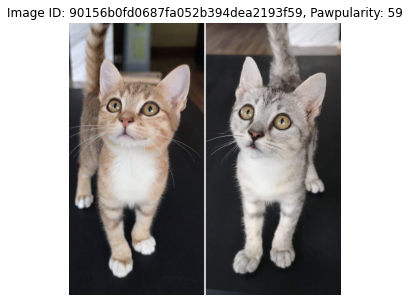

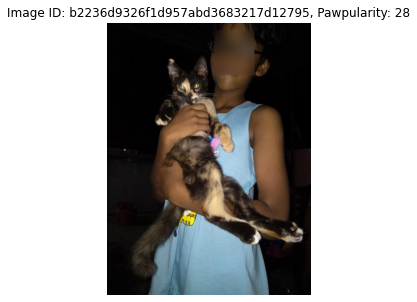

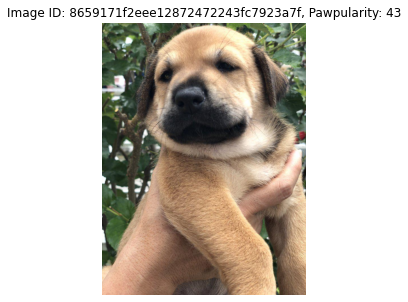

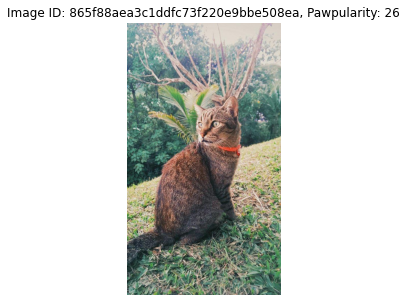

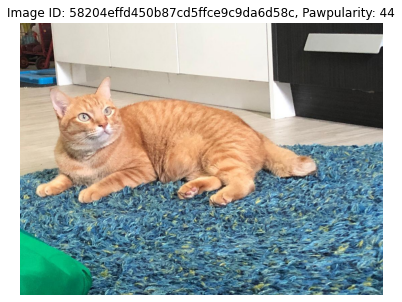

In [8]:
image_path = 'data/train/'
sample_data = df.sample(5)

for i, row in sample_data.iterrows():
    img = cv2.imread(os.path.join(image_path, row['Id'] + '.jpg'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)
    plt.title(f"Image ID: {row['Id']}, Pawpularity: {row['Pawpularity']}")
    plt.axis('off')
    plt.show()

# Explanatory Data Analysis

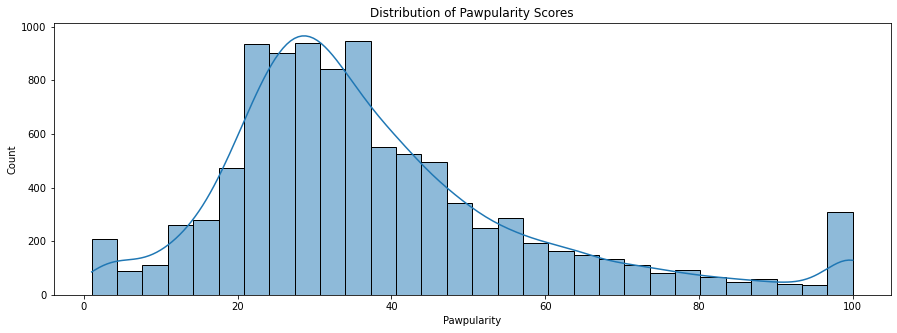

In [9]:
sns.histplot(df['Pawpularity'], bins=30, kde=True)
plt.title('Distribution of Pawpularity Scores')
plt.show()

The histogram for the distribution of Pawpularity scores shows a moderately right-skewed distribution, with most of the data concentrated between 20 and 80. The presence of a peak near the middle of the distribution indicates that many pet images have moderate Pawpularity scores, with fewer images scoring extremely low or extremely high. There is also a noticeable spike at the high end of the distribution, suggesting a small number of images with near-perfect Pawpularity scores, which could be potential outliers. This right-skewed nature implies that while most images perform moderately well, a significant number have lower scores, and only a few achieve very high Pawpularity.